In [49]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow keras

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os

## Carregando os dados e colocando a coluna 'Date' como índice

In [51]:
caminho_pasta = 'Base_dados'
lista_arquivos = [arquivo for arquivo in os.listdir(caminho_pasta) if os.path.isfile(os.path.join(caminho_pasta, arquivo))]

for arq in lista_arquivos:
    df = pd.read_csv(f'Base_dados/{arq}', parse_dates=['Date'])
    df = df.sort_values('Date')
    # Verificar se a coluna 'Date' existe e definir como índice
    # if 'Date' in df.columns:
    #     df = df.set_index('Date')
    print(df.head())


        Date    Open       High        Low      Close  Adj Close      Volume  \
0 2020-01-29  25.500  25.690001  24.680000  24.730000  18.055990  16800400.0   
1 2020-01-30  24.350  24.995001  24.184999  24.900000  18.180117  25079800.0   
2 2020-01-31  24.555  24.559999  24.110001  24.270000  17.720137  32252800.0   
3 2020-02-03  24.275  24.570000  24.004999  24.389999  17.807749  20402800.0   
4 2020-02-04  24.645  24.799999  24.125000  24.125000  17.614269  23533200.0   

    SMA_10     EMA_10     RSI_10      MACD  MACD_Histogram  BBL_20_2.0  \
0  24.9610  25.132101  40.316762 -0.407259        0.043456   23.842415   
1  24.9785  25.089901  43.272728 -0.397243        0.042777   23.898938   
2  24.8995  24.940828  35.942692 -0.435126        0.003916   23.906795   
3  24.8485  24.840677  38.159656 -0.450275       -0.008986   23.925546   
4  24.8430  24.710554  35.172752 -0.478152       -0.029490   23.906871   

   BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0   ATRr_14    stoch_k  \


In [52]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_10', 'EMA_10', 
            'RSI_10', 'MACD', 'MACD_Histogram', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 
            'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14', 'stoch_k', 'stoch_d']

target = 'Adj Close'

X = df[features]
y = df[target]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = y.values

In [53]:
window_size = 60

X_seq = []
y_seq = []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i-window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)



In [54]:
train_size = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))



In [55]:
model.compile(optimizer='adam', loss='mse')



In [56]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
25/25 [==============================] - 1s 11ms/step - loss: 26857.8457 - val_loss: 2570.8730
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 2594.2742 - val_loss: 841.9714
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 1333.6304 - val_loss: 717.2995
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 1151.8546 - val_loss: 590.1642
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 1037.6581 - val_loss: 549.5345
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 909.6924 - val_loss: 495.8320
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 787.7103 - val_loss: 446.6718
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 674.1347 - val_loss: 392.8998
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 585.7014 - val_loss: 418.2241
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 5

11/11 [==============================] - 0s 2ms/step
MSE: 142.5060842969107
MAE: 9.061318924177938


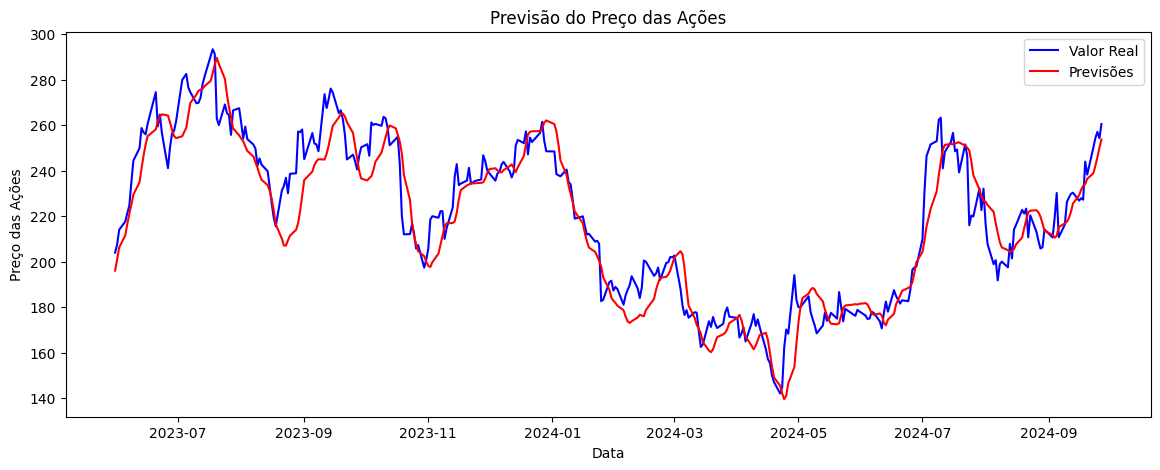

In [57]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
# Primeiro, precisamos saber os índices correspondentes aos dados de teste
test_dates = df['Date'][-len(y_test):]
test_dates = test_dates.reset_index(drop=True)

plt.figure(figsize=(14,5))
plt.plot(test_dates, y_test, color='blue', label='Valor Real')
plt.plot(test_dates, y_pred, color='red', label='Previsões')
plt.title('Previsão do Preço das Ações')
plt.xlabel('Data')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()




In [58]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_10,EMA_10,RSI_10,MACD,MACD_Histogram,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,ATRr_14,stoch_k,stoch_d
0,2020-01-30,42.161331,43.391998,41.200001,42.720669,42.720669,435085500.0,37.496600,37.734858,85.787607,2.639939,0.550914,27.812377,34.837566,41.862756,40.331117,1.061060,1.971172,87.117057,81.736019
1,2020-01-31,42.666668,43.533333,42.167999,43.371334,43.371334,235789500.0,38.410467,38.759672,86.677273,2.930907,0.673505,28.210692,35.571933,42.933175,41.387919,1.029761,1.915179,93.899932,87.137657
2,2020-02-03,44.912666,52.409332,44.901333,52.000000,52.000000,705975000.0,40.207133,41.167004,93.069622,3.813799,1.245117,26.906177,36.695233,46.484289,53.353283,1.281728,2.559948,96.906199,92.641063
3,2020-02-04,58.863998,64.599335,55.591999,59.137333,59.137333,914082000.0,42.472867,44.434337,95.190505,5.031421,1.970192,24.751718,38.146966,51.542215,70.229691,1.283500,3.451703,93.073154,94.626429
4,2020-02-05,54.883999,56.398666,46.940666,48.980000,48.980000,726357000.0,43.573800,45.260821,64.148610,5.117789,1.645248,25.237119,39.032433,52.827747,70.686417,0.860541,4.215197,77.197608,89.058987


In [59]:
years = df['Date'].dt.year.unique()

mses = []
maes = []

for year in years[:-1]:  # Excluindo o último ano para ter dados para testar
    # Dados de treinamento até o ano atual
    train_data = df[df['Date'].dt.year <= year]
    test_data = df[df['Date'].dt.year == year+1]
    
    if len(test_data) < window_size:
        continue  # Pula se não houver dados suficientes para testar
    
    # Preparar dados de treinamento
    X_train = train_data[features].values
    y_train = train_data[target].values
    X_train_scaled = scaler.fit_transform(X_train)
    
    X_train_seq = []
    y_train_seq = []
    for i in range(window_size, len(X_train_scaled)):
        X_train_seq.append(X_train_scaled[i-window_size:i])
        y_train_seq.append(y_train[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # Preparar dados de teste
    X_test = test_data[features].values
    y_test = test_data[target].values
    X_test_scaled = scaler.transform(X_test)
    
    X_test_seq = []
    y_test_seq = []
    for i in range(window_size, len(X_test_scaled)):
        X_test_seq.append(X_test_scaled[i-window_size:i])
        y_test_seq.append(y_test[i])
    X_test_seq = np.array(X_test_seq)
    y_test_seq = np.array(y_test_seq)
    
    # Verificar se há dados suficientes
    if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
        continue
    
    # Construir e treinar o modelo
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)
    
    # Fazer previsões
    y_pred = model.predict(X_test_seq)
    
    # Calcular métricas
    mse = mean_squared_error(y_test_seq, y_pred)
    mae = mean_absolute_error(y_test_seq, y_pred)
    mses.append(mse)
    maes.append(mae)
    
    print(f'Ano {year+1}: MSE = {mse}, MAE = {mae}')

mean_mse = np.mean(mses)
std_mse = np.std(mses)
mean_mae = np.mean(maes)
std_mae = np.std(maes)

print(f'\nMédia MSE: {mean_mse}, Desvio Padrão MSE: {std_mse}')
print(f'Média MAE: {mean_mae}, Desvio Padrão MAE: {std_mae}')



6/6 [==============================] - 0s 2ms/step
Ano 2021: MSE = 1698.938163849889, MAE = 35.36775875091553
6/6 [==============================] - 0s 2ms/step
Ano 2022: MSE = 1182.9479157848239, MAE = 29.733143831422815
6/6 [==============================] - 0s 2ms/step
Ano 2023: MSE = 264.98511448506093, MAE = 12.915753254137538
4/4 [==============================] - 0s 2ms/step
Ano 2024: MSE = 224.26420341316955, MAE = 11.99729258619894

Média MSE: 842.7838493832357, Desvio Padrão MSE: 625.5257254405283
Média MAE: 22.503487105668704, Desvio Padrão MAE: 10.247709317497206


In [60]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=16, verbose=0)

